## Automated Stock Trading

In [1]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

In [2]:
## API Library Setup
import os

## Robinhood API Setup
import robin_stocks as rs
# Connecting to RobinHood
rs.login(
    username = os.getenv("RH_LOGIN"),
    password = os.getenv("RH_PASS"),
    expiresIn = 3600*24,
    by_sms = True
)

## Alpaca API Setup
import alpaca_trade_api as tradeapi
# Connecting to Alpaca
api = tradeapi.REST(os.getenv("AP_KEY"),os.getenv("AP_SECRET"), api_version='v2')

In [3]:
N_DAYS_AGO = 365
OLS_Window = 5
min_list_years = 5
min_volume = 400000
max_investment = float(rs.build_user_profile()['equity'])*0.2
min_investment = 15

In [13]:
%matplotlib inline
## Installing Required Packages
import sys
from time import sleep
import math
import pickle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from scipy import stats

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

Group_Consolidator.py
RH_API_Helpers.py
Stock_Consolidator.py
Technical_Indicators.py


### Historical Data Pull

In [5]:
## Pulling All Available Alpaca Symbols
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets \
                if i._raw['tradable'] \
                    & i._raw['shortable'] \
                    & i._raw['easy_to_borrow']]

## Pulling All Bar Data
s_inc = 100
print("Starting Initial Data Pull")
Splits = [0]
while Splits[len(Splits)-1] < (len(Final_Assets)-1):
    if Splits[len(Splits)-1] + s_inc > (len(Final_Assets)-1):
        Splits.append((len(Final_Assets)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + s_inc)
Initial_Bars = {}
for i in tqdm(range(1,len(Splits))):
    Initial_Bars.update(api.get_barset(symbols = Final_Assets[Splits[i-1]:Splits[i]],
                                      timeframe = 'day',
                                      limit = N_DAYS_AGO))

print("Filtering Based On Average Price and Volume")
## Filtering Based On Price And Volume Criteria
Stocks = []
for i in tqdm(Final_Assets):
    try:
        Price_Data = Initial_Bars[i].df
        Price = np.mean(Price_Data['close'])
        Volume = np.mean(Price_Data['volume'])
        if Price < max_investment \
        and Price > min_investment \
        and i in Final_Assets \
        and Volume > min_volume:
            Stocks.append(i)
    except:
        print("Skipped",i,"No Data")

print("Pulling Company Data")
## Pulling Polygon Company Data
Splits = [0]
while Splits[len(Splits)-1] < (len(Stocks)-1):
    if Splits[len(Splits)-1] + 50 > (len(Stocks)-1):
        Splits.append((len(Stocks)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + 50)
Company_Data = {}
for i in tqdm(range(1,len(Splits))):
    Company_Data.update(api.polygon.company(Stocks[Splits[i-1]:Splits[i]]))

## Filtering Based on Company Information
Updated_Stocks = list(Company_Data.keys())
Final_Stocks = []
for i in Updated_Stocks:
    if not Company_Data[i].active:
        continue
    if years_listed(Company_Data[i].listdate) > min_list_years:
        Final_Stocks.append(i)
        
## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

print("Formatting Final Dataset")
## Formatting Final Dataset
counter = 0
for i in tqdm(Final_Stocks):
    TMP = Initial_Bars[i].df
    TMP['date'] = TMP.index
    TMP['sector'] = Company_Data[i].sector
    TMP['industry'] = Company_Data[i].industry
    Historical_Data[i] = TMP 

## Adding Ticker Column
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]

## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

Starting Initial Data Pull



Filtering Based On Average Price and Volume


Skipped AAPL No Data

Pulling Company Data



Formatting Final Dataset


### Exploring Total Market Performance

In [6]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
Combined_Data = Combined_Data.drop_duplicates()
Combined_Data = Combined_Data[(datetime.now() - timedelta(days = N_DAYS_AGO)).strftime("%Y-%m-%d"):datetime.now().strftime("%Y-%m-%d")]

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]
Total_Market.tail(10)


,close,high,low,open,volume,count,close_diff,close_return,volume_diff,sma,RSI,MACD
date,,,,,,,,,,,,
2020-10-06 00:00:00-04:00,67.750090,69.586961,67.267851,68.545345,3.231374e+06,1084.0,-0.007700,0.028810,0.149894,67.214049,42.802374,0.280613
2020-10-07 00:00:00-04:00,69.038571,69.729334,67.944242,68.493205,2.829162e+06,1084.0,0.019018,0.042218,-0.124471,67.773374,45.992659,0.366302
2020-10-08 00:00:00-04:00,69.755000,70.432524,68.713562,69.576258,2.977631e+06,1084.0,0.010377,0.043424,0.052478,68.353972,46.405785,0.446302
2020-10-09 00:00:00-04:00,70.224737,71.108909,69.406439,70.303953,2.831609e+06,1083.0,0.006734,0.048907,-0.049040,69.008845,44.593734,0.501781
2020-10-12 00:00:00-04:00,70.541075,71.381011,69.677821,70.589723,2.722392e+06,1084.0,0.004505,0.033178,-0.038571,69.461895,48.070515,0.528051
2020-10-13 00:00:00-04:00,70.145868,71.184334,69.351046,70.293216,2.995879e+06,1084.0,-0.005603,0.035362,0.100458,69.941050,47.305960,0.488023
2020-10-14 00:00:00-04:00,69.867635,71.179676,69.326427,70.329242,3.016610e+06,1084.0,-0.003966,0.012009,0.006920,70.106863,61.690462,0.414891
2020-10-15 00:00:00-04:00,70.091710,70.528488,68.418238,68.929074,2.865425e+06,1084.0,0.003207,0.004827,-0.050117,70.174205,65.804122,0.355955
2020-10-16 00:00:00-04:00,70.003208,71.129546,69.477499,70.331940,2.993897e+06,1084.0,-0.001263,-0.003155,0.044835,70.129899,63.570780,0.288247


In [51]:
## Run to Update Total Market Data
Total_Market.to_csv(Project_Folder + "Data//Historical_Data.csv")

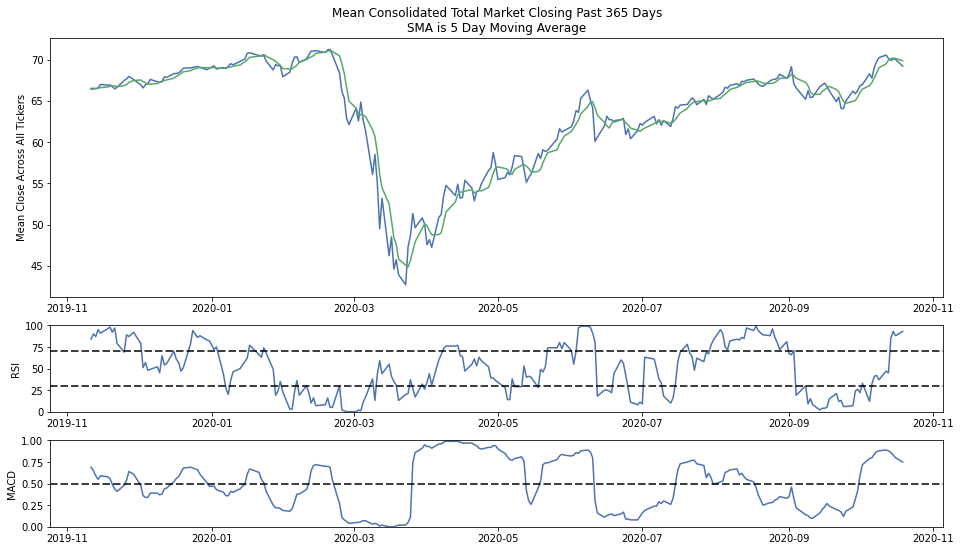

In [7]:
Plot_Data = Total_Market
Plot_Data['RSI'] = pd.qcut(Plot_Data.RSI,100,labels = False)
# Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100
Plot_Data['MACD'] = pd.qcut(Plot_Data.MACD,100,labels = False)/100
# Plot_Data['MACD'] = (1 + 1)*((Plot_Data['MACD'] -  np.min(Plot_Data['MACD'])) / (np.max(Plot_Data['MACD']) - np.min(Plot_Data['MACD']))) - 1

Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0.50,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(OLS_Window) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(
    ylabel = "MACD",
    xlabel = "",
    ylim = [0,1]
)
fig.set_size_inches(16,9)

In [9]:
## Calculating Market Deciders
Market_Strength = np.mean(Total_Market.RSI.tail(5))/100
Market_Momentum = (np.mean(Plot_Data.MACD.tail(5))-np.min(Plot_Data.MACD.tail(5)))/(np.max(Plot_Data['MACD'].tail(5)) - np.min(Plot_Data['MACD'].tail(5)))
print("Market Strength :",np.round(Market_Strength,3),
      "\nMarket_Momentum :",np.round(Market_Momentum,3))

Max_Beta_P = np.round(1 - Market_Momentum,3)
Min_Beta = 0.75 if Market_Momentum > 0.50 else -2
Max_Alpha_P = np.round(Market_Momentum,3)
Min_Alpha = 0 if Market_Momentum <= 0.50 else -1

print("Beta Significance :",Max_Beta_P,
     "\nAlpha Significance :",Max_Alpha_P)

Market Strength : 0.607 
Market_Momentum : 0.569
Beta Significance : 0.431 
Alpha Significance : 0.569


## Digging Into A Sector Ranking

In [8]:
Sectors = list(Combined_Data['sector'].unique())
Total_Sector_Summary = Group_Consolidator(
    Combined_Data = Combined_Data,
    groups = Sectors,
    column = 'sector'
)
Sector_Summary = Group_Consolidator(Combined_Data = Combined_Data,
                                    groups = Sectors,
                                    column = 'sector',
                                    min_macd = 0,
                                    min_alpha = 0,
                                    max_alpha_p = 0.75,
                                    max_rsi = 70
)
if len(Sector_Summary) == 0:
    Sector_Summary = list()
    print("No Viable Sectors Currently")

Sector_Summary

,last_period_return,last_price,mu_day_up,sd_day_up,mu_day_down,sd_day_down,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
sector,,,,,,,,,,,,,,
Technology,0.016368,91.936695,0.019171,0.007985,-0.009474,0.009701,1.216483,0.004191,67.562453,0.632440,0.001795,0.394,0.851596,0.074
Consumer Cyclical,0.008714,67.093801,0.020683,0.006402,-0.012130,0.008636,0.972590,0.003974,48.926096,0.228921,0.001189,0.686,0.848164,0.120
Consumer Defensive,0.007790,78.249399,0.013735,0.003696,-0.007923,0.005428,0.656100,0.002449,58.686141,0.328803,0.001070,0.466,0.769268,0.002
Industrials,0.007857,81.547762,0.017529,0.006137,-0.008541,0.007717,0.753530,0.003830,52.525413,0.368603,0.000404,0.490,1.109511,0.004


## Diving Further Into Individual Idustries

In [9]:
if type(Sector_Summary) is not list:
    Top_Sector = Combined_Data[Combined_Data['sector'].isin(Sector_Summary.index.values)]
    Industries = list(Top_Sector['industry'].unique())
    Industry_Summary = Group_Consolidator(Combined_Data = Top_Sector,
                                          groups = Industries,
                                          column = 'industry',
                                          min_macd = 0,
                                          min_alpha = 0,
                                          max_alpha_p = 0.75,
                                          max_rsi = 70,
                                          min_risk_ratio = 1
                                         )
else:
    print("No sectors to loop through")
    Industry_Summary = list()
Industry_Summary

,last_period_return,last_price,mu_day_up,sd_day_up,mu_day_down,sd_day_down,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
industry,,,,,,,,,,,,,,
Retail - Apparel & Specialty,0.020816,99.464218,0.021656,0.009705,-0.012388,0.011390,1.111957,0.004367,56.400870,0.448754,0.004235,0.582,0.119075,0.768
Beverages - Non-Alcoholic,0.019737,91.151000,0.010246,0.008427,-0.008006,0.009299,1.325202,0.000975,55.049684,0.350578,0.003248,0.368,0.622760,0.536
Restaurants,0.010700,67.711954,0.017741,0.005240,-0.012693,0.007355,1.331981,0.002403,46.122859,0.132856,0.001896,0.598,0.735443,0.250
Semiconductors,0.020432,87.341014,0.023539,0.013865,-0.009164,0.013333,1.125827,0.007465,69.278921,0.794715,0.001340,0.372,0.678572,0.340


## Diving Into The Individual Stocks

In [10]:
if type(Industry_Summary) is not list:
    Top_Industry = Top_Sector[Top_Sector['industry'].isin(Industry_Summary.index.values)]
    Stocks = list(Top_Industry['stock'].unique())
    Stock_Summary = Group_Consolidator(Combined_Data = Top_Industry,
                                       groups = Stocks,
                                       column = 'stock',
                                       min_macd = 0,
                                       min_alpha = 0,
                                       max_alpha_p = 0.50,
                                       max_rsi = 50
    )
    Stock_Summary. \
        sort_values(by = ['rsi'],ascending = [1])
else:
    print("No industries to loop through")
    Stock_Summary = list()
Stock_Summary

,last_period_return,last_price,mu_day_up,sd_day_up,mu_day_down,sd_day_down,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
stock,,,,,,,,,,,,,,
SIG,0.104532,22.478,0.037940,0.014788,-0.016361,0.024873,0.812366,0.018514,41.349923,0.216933,0.018436,0.066,-0.544715,0.450
MU,0.055483,51.945,0.018123,0.019226,-0.008864,0.023290,0.377498,0.003060,48.447486,0.308230,0.009360,0.272,-0.227872,0.646
FIVE,0.042167,136.610,0.022246,0.009139,-0.008926,0.015410,0.706794,0.006540,40.245050,0.246561,0.007420,0.334,0.478772,0.394
YUM,0.032085,97.556,0.015867,0.010044,-0.007603,0.008586,1.569349,0.005123,42.460247,0.601082,0.006840,0.242,1.228730,0.252
JACK,0.029480,85.684,0.019259,0.009639,-0.010012,0.011822,0.542177,0.006553,45.915999,0.441069,0.006498,0.040,1.251451,0.060
BBY,0.036114,119.496,0.017866,0.012458,-0.006014,0.011799,0.645735,0.006860,49.949383,0.694055,0.005926,0.198,0.939413,0.272
MNST,0.023064,81.654,0.012612,0.009868,-0.008668,0.011026,1.659826,0.000283,49.544534,0.348602,0.003218,0.384,0.471046,0.550


In [62]:
rs.cancel_all_stock_orders()

Found Additional pages.
Loading page 2 ...
Loading page 3 ...
Loading page 4 ...
Loading page 5 ...
All Stock Orders Cancelled


[{'id': '3e548696-3f4a-4ce8-86c0-1cdbcf622dd6',
  'ref_id': '54af4cd1-e7d6-4e06-b217-f427aa3c8cc6',
  'url': 'https://api.robinhood.com/orders/3e548696-3f4a-4ce8-86c0-1cdbcf622dd6/',
  'account': 'https://api.robinhood.com/accounts/507496313/',
  'position': 'https://api.robinhood.com/positions/507496313/41922140-9b71-4025-b960-51577767e5a8/',
  'cancel': 'https://api.robinhood.com/orders/3e548696-3f4a-4ce8-86c0-1cdbcf622dd6/cancel/',
  'instrument': 'https://api.robinhood.com/instruments/41922140-9b71-4025-b960-51577767e5a8/',
  'cumulative_quantity': '0.00000000',
  'average_price': None,
  'fees': '0.00',
  'state': 'queued',
  'type': 'market',
  'side': 'sell',
  'time_in_force': 'gfd',
  'trigger': 'immediate',
  'price': '13.89000000',
  'stop_price': None,
  'quantity': '12.12000000',
  'reject_reason': None,
  'created_at': '2020-10-20T01:02:06.840143Z',
  'updated_at': '2020-10-20T01:02:06.840155Z',
  'last_transaction_at': '2020-10-20T01:02:06.840143Z',
  'executions': [],
 

In [11]:
## Pulling Current Stock Holdings
my_stocks = rs.build_holdings()
Current_Holdings = pd.DataFrame({key:value for key,value in my_stocks.items()})

## Combining Lists
Stocks = list(Current_Holdings.keys())
if len(Stock_Summary) != 0:
    Stocks.extend(list(Stock_Summary.index))
Stocks = list(set(Stocks))

## Pulling Historical Data
Stock_Data = pd.DataFrame()
for Stock in Stocks:
    Stock_Data[Stock] = Combined_Data['close'][Combined_Data.stock == Stock].tail(5*3)
    
## Creating expected mean and variance matricies
mu = expected_returns.mean_historical_return(Stock_Data)#returns.mean() * 252
S = risk_models.sample_cov(Stock_Data) #Get the sample covariance matrix

## Optimizing Sharpe Ratio
ef = EfficientFrontier(
    expected_returns = mu,
    cov_matrix = S, 
    weight_bounds = (0,0.2),
    verbose = False
)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 

## Subsetting Stock Picks
Final_Picks = []
for stock in cleaned_weights.keys():
    if cleaned_weights[stock] > 0:
        print(stock," : ",cleaned_weights[stock])
        Final_Picks.append(stock)
        
Optimized_Portfolio = ef.portfolio_performance(verbose=True)

MU  :  0.07522
ACN  :  0.2
SIG  :  0.2
MNST  :  0.13461
YUM  :  0.15275
SSNC  :  0.2
CEF  :  0.03743
Expected annual return: 1912.9%
Annual volatility: 17.6%
Sharpe Ratio: 108.32


## Robinhood Automated Investing POC

In [15]:
## Pulling Relevent Account Information
Account_Equity = float(rs.build_user_profile()['equity'])

## Pulling Open Orders
Open_Orders = Get_Open_Orders()

## Pulling Current Stock Holdings
Current_Holdings = Get_Holdings()

## Checking Portfolio Balancing And Placing New Orders
for s in Final_Picks:

    # Optimal Portfolio Percentage
    Rcm_Holding = cleaned_weights[s]*100
    
    # Portfolio Restructuring
    if s in list(Current_Holdings.keys()):
        
        # Current Portfolio Percentage
        Pct_Holding = np.round(float(Current_Holdings[s].equity)*100/Account_Equity,2)

        # Rebalancing If Beyond Recommended Holding
        if Pct_Holding > Rcm_Holding*1.05:
            Rebalance_Lower(s)
            
        # Checking If More Needs Purchased
        elif Pct_Holding < Rcm_Holding*0.95:
            Rebalance_Higher(s)
            
        # Make No Changes    
        else:
            print("\n",s," Within Recommended Percentage")
            
    ## Stocks Not Currently Held
    else:
        Open_Position(s)
        
## Closing Required Positions
for s in [s for s in list(Current_Holdings.keys()) if s not in Final_Picks]:
    Close_Position(s)

Found Additional pages.
Loading page 2 ...
Loading page 3 ...
Loading page 4 ...
Loading page 5 ...

Opening MU Position

Rebalancing ACN : Currently = 11.35 , Target = 20.0
Buying  105.0
Order ID: 073c1234-d068-4cd6-95ed-35fec313e984 placed

Opening SIG Position

Opening MNST Position

Opening YUM Position

 SSNC  Within Recommended Percentage

 CEF  Within Recommended Percentage


In [33]:
Current_Holdings

,MSFT,CDNS,SSNC,CEF,KKR,ACN
price,216.150000,114.400000,63.900000,18.730000,36.800000,226.262600
quantity,1.09896800,2.12103900,3.01000000,12.12000000,3.16000000,0.60430000
average_buy_price,220.2066,115.5095,64.8339,18.9802,37.2690,231.5241
equity,237.54,242.65,192.34,227.01,116.29,136.73
percent_change,-1.84,-0.96,-1.44,-1.32,-1.26,-2.27
equity_change,-4.458074,-2.353293,-2.811039,-3.032424,-1.482040,-3.179524
type,stock,stock,stock,cef,stock,stock
name,Microsoft,Cadence Design Systems,SS&C Technologies,Sprott Physical Gold and Silver Trust,KKR & Co,Accenture
id,50810c35-d215-4866-9758-0ada4ac79ffa,30cdd673-98fd-4550-b3c7-3c5536587033,821db08b-ff6b-448a-90f9-2085901ac60b,41922140-9b71-4025-b960-51577767e5a8,60eaa78b-b046-4810-8fb4-f762ae3b5014,ac6ddf2b-ef9e-4221-a1fe-fde5ceaa8f99
pe_ratio,38.112300,31.819700,33.813700,5.893460,136.360000,29.139800
